In [13]:
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [14]:
df=pd.read_csv(r'./rq_1_2.csv')

In [15]:
df.head()

,product,issue_id,part_of_day_commit,committer,hash,commit_time,message_sentiment,issuetype,priority,category
0,HBASE,12475576,Afternoon,9c09de0ec2e84e73ffcb00c42f1f6d1aee9a691e,71d6b124dda724f009fd6aa3745ce200e52f2b69,2010-10-09 17:55:33+00:00,neutral,Bug,Major,high
1,HBASE,12735211,Morning,19478cd273e35eef37c1cb3dd0a392aca8b0cc5c,a2fc3efebfb277d2e57712a4c5b210a01fd7d5c8,2014-08-22 17:29:02+00:00,neutral,non-bug,Major,high
2,HBASE,12680854,Night,7c94307aaacec5fedf5b2d2e1c47a2ce9011455c,770e336ef691c589f40cf81ee97438b37effc7e4,2013-11-27 23:57:23+00:00,neutral,non-bug,Major,high
3,HBASE,12730369,Afternoon,9dad60d64119edbb80f0bc9e3be886922462ba05,8a52d58a7ba5f87a771b1b6f803381a1c0b9909b,2014-08-19 20:51:17+00:00,neutral,non-bug,Major,high
4,HBASE,12731642,Afternoon,76e26a0edc0b9f902cd7ca1c7e30b5fb167b7d77,76ffc75036a932a98923b9ed4196c5ebe0887d3b,2014-08-18 21:23:37+00:00,neutral,non-bug,Major,high


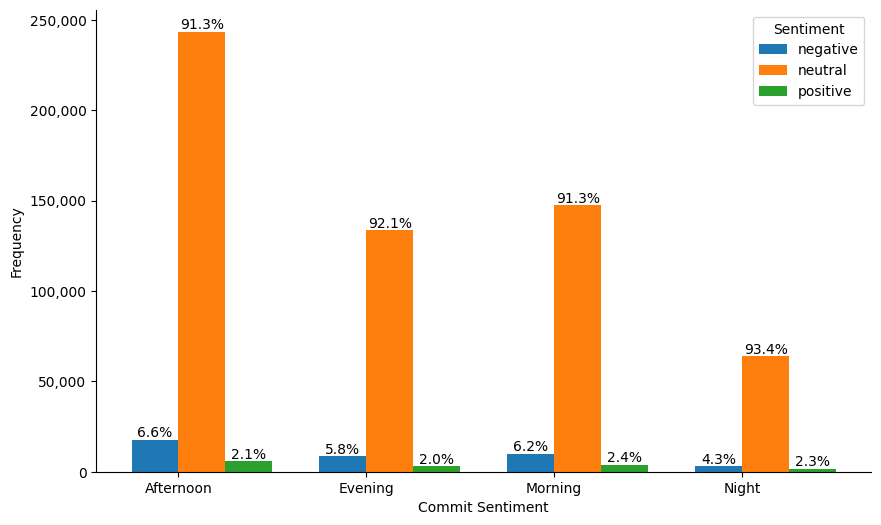

In [16]:
grouped = df.groupby(['part_of_day_commit', 'message_sentiment']).size().unstack(fill_value=0)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))  

sentiments = grouped.columns
issue_types = grouped.index

bar_width = 0.25
bar_positions = list(range(len(issue_types)))

for i, sentiment in enumerate(sentiments):
    offset = i * bar_width - bar_width / 2

    bars = plt.bar([pos + offset for pos in bar_positions], grouped[sentiment], width=bar_width, label=sentiment)
    
    for bar, pct in zip(bars, grouped_percent[sentiment]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)


# Customize plot
plt.xlabel('Commit Sentiment')
plt.ylabel('Frequency')
# plt.title('Sentiment Frequencies by Issue Type')
plt.xticks(bar_positions, issue_types)
plt.legend(title='Sentiment', loc='upper right')
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False)  
plt.gca().get_xaxis().tick_bottom() 
plt.gca().get_yaxis().tick_left()  
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(False)
plt.show()

In [21]:
rq2 = df.groupby(['part_of_day_commit', 'message_sentiment']).size()
rq2 = rq2.unstack().reset_index()
rq2.columns.name=None

In [18]:
rq2

,part_of_day_commit,negative,neutral,positive
0,Afternoon,17623,243483,5704
1,Evening,8432,133617,2963
2,Morning,10037,147416,3946
3,Night,2945,63875,1587


In [19]:
contingency_table = rq2.set_index('part_of_day_commit')[['negative', 'positive', 'neutral']].T
print("Contingency Table:")
print(contingency_table)

# Perform the Chi-square test
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-squared statistic: {chi2}\np-value: {p_chi2}\nDegree of Freedom (dof): {dof}")

# Create a rq1Frame for the expected frequencies
expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print("\nExpected Frequency Table:")
print(expected_df)

# Interpret the Chi-square test results
if p_chi2 < 0.05:
    print('\nChi-squared test: There is a statistically significant association between part of day commit made and the sentiment counts (negative, positive, neutral).')
else:
    print('\nChi-squared test: There is no significant association between part of day commit made and the sentiment counts (negative, positive, neutral).')

Contingency Table:
part_of_day_commit  Afternoon  Evening  Morning  Night
negative                17623     8432    10037   2945
positive                 5704     2963     3946   1587
neutral                243483   133617   147416  63875

Chi-squared statistic: 597.4521877544643
p-value: 8.266654272471644e-126
Degree of Freedom (dof): 6

Expected Frequency Table:
part_of_day_commit      Afternoon        Evening        Morning         Night
negative             16232.866973    8822.609743    9819.603825   4161.919460
positive              5904.826473    3209.290118    3571.954154   1513.929255
neutral             244672.306555  132980.100139  148007.442021  62731.151285

Chi-squared test: There is a statistically significant association between part of day commit made and the sentiment counts (negative, positive, neutral).


In [22]:
rq2['total_sentiments'] = rq2['negative'] + rq2['positive'] + rq2['neutral']

# Calculate the negative sentiment percentage
rq2['negative_percentage'] = (rq2['negative'] / rq2['total_sentiments']) * 100

# Extract the negative sentiment counts and total sentiment counts
negatives = rq2['negative'].values
totals = rq2['total_sentiments'].values



In [23]:
negatives   ## afternoon , evening , morning , night

array([17623,  8432, 10037,  2945], dtype=int64)

In [25]:
totals       ## total afternoon , total evening , total morning , total night

array([266810, 145012, 161399,  68407], dtype=int64)

In [26]:
prop_afternoon = negatives[0] / totals[0]

prop_evening = negatives[1] / totals[1]

prop_morning = negatives[2] / totals[2]

prop_night = negatives[3] / totals[3]

In [27]:
# Performing z-test for low vs medium and low vs high
count_afternoon_evening = [negatives[0], negatives[1]]
nobs_afternoon_evening = [totals[0], totals[1]]
z_stat_afternoon_evening, p_value_afternoon_evening = proportions_ztest(count_afternoon_evening, nobs_afternoon_evening)


count_afternoon_morning = [negatives[0], negatives[2]]
nobs_afternoon_morning = [totals[0], totals[2]]
z_stat_afternoon_morning, p_value_afternoon_morning = proportions_ztest(count_afternoon_morning, nobs_afternoon_morning)


count_afternoon_night = [negatives[0], negatives[3]]
nobs_afternoon_night = [totals[0], totals[3]]
z_stat_afternoon_night, p_value_afternoon_night = proportions_ztest(count_afternoon_night, nobs_afternoon_night)



# Print the results
print(f"Negative Sentiment Proportions:\nAfternoon: {prop_afternoon * 100:.2f}%\nEvening: {prop_evening * 100:.2f}%\nMorning: {prop_morning * 100:.2f}%\nNight: {prop_night * 100:.2f}")
print(f"\nZ-test Results:")
print(f"Afternoon vs Evening: Z-statistic = {z_stat_afternoon_evening:.4f}, P-value = {p_value_afternoon_evening:.4f}")
print(f"Afternoon vs Morning: Z-statistic = {z_stat_afternoon_morning:.4f}, P-value = {p_value_afternoon_evening:.4f}")
print(f"Afternoon vs Night: Z-statistic = {z_stat_afternoon_night:.4f}, P-value = {p_value_afternoon_night:.4f}")


# Interpret the results
if p_value_afternoon_night < 0.05 and p_value_afternoon_evening < 0.05 and p_value_afternoon_morning:
    print("\nThe hypothesis that low committer frequency has a significantly different negative sentiment percentage is supported.")
else:
    print("\nThe hypothesis is not supported.")

Negative Sentiment Proportions:
Afternoon: 6.61%
Evening: 5.81%
Morning: 6.22%
Night: 4.31

Z-test Results:
Afternoon vs Evening: Z-statistic = 9.9515, P-value = 0.0000
Afternoon vs Morning: Z-statistic = 4.9840, P-value = 0.0000
Afternoon vs Night: Z-statistic = 22.3628, P-value = 0.0000

The hypothesis that low committer frequency has a significantly different negative sentiment percentage is supported.
